In [1]:
from pprint import pprint

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from prepare import basic_clean, lemmatize

In [2]:
document = 'Mary had a little lamb, a little lamb, a little lamb.'

# clean up the text
document = document.lower().replace(',', '').replace('.', '')
# transform into a series
words = pd.Series(document.split())

# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
little,3,0.272727,1.000000
a,3,0.272727,1.000000
lamb,3,0.272727,1.000000
mary,1,0.090909,0.333333
had,1,0.090909,0.333333


Text(0.5, 1.0, 'IDF for a given word')

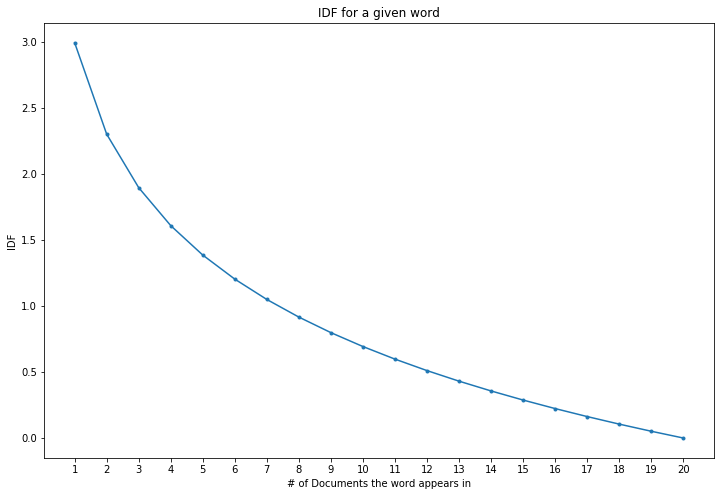

In [3]:
n_documents = 20

x = np.arange(1, n_documents + 1)
y = np.log(n_documents / x)

plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='.')

plt.xticks(x)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

In [4]:
# our 3 example documents
documents = {
    'news': 'Codeup announced last thursday that they just launched a new data science program. It is 18 weeks long.',
    'description': 'Codeup\'s data science program teaches hands on skills using Python and pandas.',
    'context': 'Codeup\'s data science program was created in response to a percieved lack of data science talent, and growing demand.'
}
pprint(documents)

print('\nCleaning and lemmatizing...\n')

documents = {topic: lemmatize(basic_clean(documents[topic])) for topic in documents}
pprint(documents)

{'context': "Codeup's data science program was created in response to a "
            'percieved lack of data science talent, and growing demand.',
 'description': "Codeup's data science program teaches hands on skills using "
                'Python and pandas.',
 'news': 'Codeup announced last thursday that they just launched a new data '
         'science program. It is 18 weeks long.'}

Cleaning and lemmatizing...

{'context': "codeup 's datum science program be create in response to a "
            'percieve lack of datum science talent and grow demand',
 'description': "codeup 's datum science program teach hand on skill use "
                'python and panda',
 'news': 'codeup announce last thursday that -PRON- just launch a new datum '
         'science program -PRON- be 18 week long'}


In [5]:
# A simple way to calculate idf for demonstration. Note that this
# function relies on the globally defined documents variable.
def idf(word):
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences

# Get a list of the unique words
unique_words = pd.Series(' '.join(documents.values()).split()).unique()

# put the unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False)
 .head(5))

,idf
word,
teach,3.0
announce,3.0
grow,3.0
talent,3.0
of,3.0


In [6]:
tfs = []

# We'll caclulate the tf-idf value for every word across every document

# Start by iterating over all the documents
for doc, text in documents.items():
    # We'll make a data frame that contains the tf for every word in every document
    df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(df)

# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False))

,word,doc,tf_idf
0,-PRON-,news,0.352941
0,teach,description,0.230769
11,use,description,0.230769
9,skill,description,0.230769
8,python,description,0.230769
5,hand,description,0.230769
7,panda,description,0.230769
7,launch,news,0.176471
15,announce,news,0.176471
1,week,news,0.176471


In [7]:
# We'll then concatenate all the tf values together.
(pd.concat(tfs)
 # calculate the idf value for each word
 .assign(idf=lambda df: df.word.apply(idf))
 # then use the if and idf values to calculate tf-idf 
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False)
 .pipe(lambda df: pd.crosstab(df.doc, df.word, values=df.tf_idf, aggfunc=lambda x: x))
 .fillna(0))

word,'s,-PRON-,18,a,and,announce,be,codeup,create,datum,...,response,science,skill,talent,teach,that,thursday,to,use,week
doc,,,,,,,,,,,,,,,,,,,,,
context,0.083333,0.000000,0.000000,0.055556,0.083333,0.000000,0.083333,0.055556,0.166667,0.111111,...,0.166667,0.111111,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000
description,0.115385,0.000000,0.000000,0.000000,0.115385,0.000000,0.000000,0.076923,0.000000,0.076923,...,0.000000,0.076923,0.230769,0.000000,0.230769,0.000000,0.000000,0.000000,0.230769,0.000000
news,0.000000,0.352941,0.176471,0.058824,0.000000,0.176471,0.088235,0.058824,0.000000,0.058824,...,0.000000,0.058824,0.000000,0.000000,0.000000,0.176471,0.176471,0.000000,0.000000,0.176471


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())
tfidfs

<3x34 sparse matrix of type '<class 'numpy.float64'>'
	with 44 stored elements in Compressed Sparse Row format>

In [9]:
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())

,18,and,announce,be,codeup,create,datum,demand,grow,hand,...,response,science,skill,talent,teach,that,thursday,to,use,week
0,0.250206,0.000000,0.250206,0.190288,0.147775,0.000000,0.147775,0.000000,0.000000,0.000000,...,0.000000,0.147775,0.000000,0.000000,0.000000,0.250206,0.250206,0.000000,0.000000,0.250206
1,0.000000,0.253880,0.000000,0.000000,0.197160,0.000000,0.197160,0.000000,0.000000,0.333821,...,0.000000,0.197160,0.333821,0.000000,0.333821,0.000000,0.000000,0.000000,0.333821,0.000000
2,0.000000,0.198732,0.000000,0.198732,0.154333,0.261309,0.308667,0.261309,0.261309,0.000000,...,0.261309,0.308667,0.000000,0.261309,0.000000,0.000000,0.000000,0.261309,0.000000,0.000000


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv('spam_clean.csv')
df.head()

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.text)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.44%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3857   112
spam          2   486
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3859
        spam       1.00      0.81      0.90       598

   micro avg       0.97      0.97      0.97      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.97      0.97      4457



In [21]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 95.16%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        965    53
spam         1    96
---
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       966
        spam       0.99      0.64      0.78       149

   micro avg       0.95      0.95      0.95      1115
   macro avg       0.97      0.82      0.88      1115
weighted avg       0.95      0.95      0.95      1115



In [24]:
def predict(unknown_text):
    return lm.predict(tfidf.transform([unknown_text]))[0]

In [26]:
predict('half price shakes')

'ham'

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [28]:
rfdf = pd.read_csv('spam_clean.csv')
rfdf.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [29]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(rfdf.text)
y = rfdf.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [31]:
X_train

<4457x8672 sparse matrix of type '<class 'numpy.float64'>'
	with 58936 stored elements in Compressed Sparse Row format>

In [32]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [33]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [34]:
print(rf.feature_importances_)

[0.00440435 0.00126358 0.         ... 0.         0.         0.        ]


In [35]:
y_pred = rf.predict(X_train)

In [36]:
y_pred

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

In [37]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.87


In [40]:
print(confusion_matrix(y_train, y_pred))

[[3859    0]
 [ 598    0]]


In [41]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93      3859
        spam       0.00      0.00      0.00       598

   micro avg       0.87      0.87      0.87      4457
   macro avg       0.43      0.50      0.46      4457
weighted avg       0.75      0.87      0.80      4457



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.87


In [44]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [45]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [46]:
y_pred = knn.predict(X_train)

In [47]:
y_pred

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

In [48]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.92


In [49]:
print(confusion_matrix(y_train, y_pred))

[[3859    0]
 [ 342  256]]


In [50]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         ham       0.92      1.00      0.96      3859
        spam       1.00      0.43      0.60       598

   micro avg       0.92      0.92      0.92      4457
   macro avg       0.96      0.71      0.78      4457
weighted avg       0.93      0.92      0.91      4457



In [51]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.91


([<matplotlib.axis.XTick at 0x1a24de0cc0>,
 <a list of 5 Text xticklabel objects>)

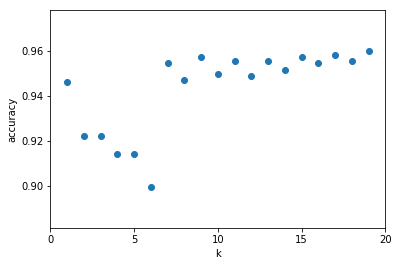

In [52]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])